<a href="https://colab.research.google.com/github/joseortegalabra/MLBI/blob/master/NN_desde_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [0]:
'''
def sigmoid(x):
    "Numerically stable sigmoid function."
    if x >= 0:
        z = exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = exp(x)
        return z / (1 + z)
'''
#funcion sigmoide
from scipy.special import expit

#funcion dervida sigmoide
def d_sigmoid(x):
  derivate = expit(x) * (1 - expit(x))
  return derivate

In [0]:
def derv_loss(y_pred, y_real):    #funcion de la derivada de la loss elegida, en mi caso mse del profe predicho - real 
#CAMBIO EL ORDEN PARA QUE QUEDE EN MATRIZ(N°DATOS, N°NEURRONAS DE ULTIMA CAPA)
  return y_pred.T - y_real.T

In [0]:
def calculate_grad_Z(grad_y, d_f_act, z):
  #mutiplicacion punto por punto del gradiente por el jacobiano

  #para evaluar el jacobiano en cada punto de Z, z tiene que estar en el formato traspuesto ocupado en back (100X1) 100 datos x 1 neurona
  z = z.T
  jacobian = d_f_act(z)
  return grad_y * jacobian

In [0]:
class model_nn():
  def __init__(self):
    #inicializar lista donde se guardaran los z, y, w, funciones de costos que utiliza el algoritmo para optimizar
    self.Z = [None]
    self.Y = [] #el y sub cero tiene un valor
    self.W = [] #dejo vacia la lista porque al crear los primeros W ahi voy a agregar el None en la primera capa
    self.b = []
    self.f_act = [None]
    self.d_f_act = [None]



    #donde guardar los valores obtenidos en cada paso de gradiente
    self.Z_hist = []
    self.Y_hist = []
    self.W_hist = []
    self.b_hist = []
  
  def reset_params(self): #reiniciar para hacer otra corrida de forward con valores W guardados y las funciones de activacion
    self.Z = [None]
    self.Y = [] 

  def add_layer(self,  n_neuron_actual, n_features = None, activation_function = None, derivate_act_function = None):
    if self.W:
      #no esta vacia la red neuronal
      self.W.append(np.random.normal(size = (n_neuron_actual, self.n_neuron_last_layer)))
      self.b.append(np.random.normal(size = (n_neuron_actual, 1)))   #llega a la cantidad actual de neuronas a partir de 1
      #AGREGAR FUNCION DE ACTIVACIÓN
      self.f_act.append(activation_function)
      self.d_f_act.append(derivate_act_function) 
      self.n_neuron_last_layer = n_neuron_actual
      

#cuando creo la nueva capa tengo que agregar el bias de la capa anterior 
    else:
      #esta vacia la red 
      self.W.append(None)
      self.b.append(None)
      self.W.append(np.random.normal(size = (n_neuron_actual, n_features)))
      self.b.append(np.random.normal(size = (n_neuron_actual, 1)))   #llega a la cantidad actual de neuronas a partir de 1
      #AGREGAR FUNCION DE ACTIVACIÓN
      self.f_act.append(activation_function) 
      self.d_f_act.append(derivate_act_function) 
      self.n_neuron_last_layer = n_neuron_actual


#podria crear solo la matriz de pesoss y las matrices Zk y Yk se crean solo cuando entreno para poder hacer variables la cantidad de datos de entrada
  
  #hacer el forward un forward pass inicial con todos los datos y las calibraciones inciiales para ver los valores en cada capa
  def forward_pass(self, data):
    self.Y.append(data)  #asigno y[k = 0] primera capa
    
    
    for k in range(1, len(self.W)):   
      #expandir dimensiones de y 
      Y_exp = np.vstack((np.ones(data.shape[1]), self.Y[k-1])) #en cada iteracion agrego el 1 
      W_exp = np.hstack(( self.b[k] , self.W[k] ))  #juntar weights y bias auxiliar para calculos
      
      self.Z.append(W_exp @ Y_exp)
      self.Y.append( self.f_act[k](self.Z[k]) )

  def backward_pass(self, y_real):
    self.N = len(self.Y) - 1  #cantidad de capas creadas (capa 0, capa 1, capa2, capa3)
    #crear gradientes en cada back y actualizarlos en la iteración
    self.grad_Y = [0 for i in range(len(self.Y))] #lista con 4 ubicaciones para hacer mis capas
    self.grad_Z = [0 for i in range(len(self.Y))] 
    self.grad_W = [0 for i in range(len(self.Y))] 
    self.grad_b = [0 for i in range(len(self.Y))] 

    while (self.N > 0):
      #print(self.N)
      self.deltaW = [0 for i in range (len(self.Y))]   #crear el delta para actualizar NOSE SI ES NECESARIO
      self.deltab = [0 for i in range (len(self.Y))] 
 
      
      if (self.N  == len(self.Y) - 1):   #solo para la ultima capa
        self.grad_Y[self.N] =  derv_loss(self.Y[self.N], y_real)   #derivada de la Loss


      else:  #caso contrario que no estoy en la ultima capa
      #LOS VALORES LOS AGREGO EN EL ORDEN INVERSO, TENGO QUE AGREGAR UNA ESPACIO NULO Y SUFFLE DE LO QUE OBTENGO, ahi queda ordenado de 0,1,2,3
        self.grad_Y[self.N] = self.grad_Z[self.N + 1] @ self.W[self.N + 1]

      #calcular gradiente de z y de w da lo mismo en la capa en la que estoy
      self.grad_Z[self.N] =  calculate_grad_Z(self.grad_Y[self.N], self.d_f_act[self.N],self.Z[self.N])
      self.grad_W[self.N] = self.Y[self.N - 1] @ self.grad_Z[self.N]
      self.grad_b[self.N] = np.ones((1, self.Y[0].shape[1])) @ self.grad_Z[self.N] #ones de los datos self.Y[0].shape[1] cantidad de datos en todos los y son =
      self.N -=1

  def update_weights(self, lr):
    for k in range(1, len(self.W)):
      self.W[k] = self.W[k] - ( lr /  self.Y[0].shape[1] ) * self.grad_W[k].T
      self.b[k] = self.b[k] - ( lr /  self.Y[0].shape[1] ) * self.grad_b[k].T

# MODELO ENTRENAR

In [6]:
X = np.array([
              [25, 50, 1, 10],
              [25, 20, 0, 10],
              [20, 50, 1, 10 ],
              [10, 60, 0, 20 ],
              [10, 30, 0, 5 ],
              [10, 20, 1, 5 ]
])

y = np.array([[3, 2, 3, 3, 2, 1]])
print('Data x', X)
print('Data y', y)

Data x [[25 50  1 10]
 [25 20  0 10]
 [20 50  1 10]
 [10 60  0 20]
 [10 30  0  5]
 [10 20  1  5]]
Data y [[3 2 3 3 2 1]]


#### conjunto train y test

In [7]:
X_train = X.T
y_train = y
print(X_train) #datos ordenados de forma correcta en el eje y los valores de las features
print('y_train en horizontal los datos', y_train)

[[25 25 20 10 10 10]
 [50 20 50 60 30 20]
 [ 1  0  1  0  0  1]
 [10 10 10 20  5  5]]
y_train en horizontal los datos [[3 2 3 3 2 1]]


In [0]:
#hacer batch de 3 DATOS

#### hacer red y entrenar

In [9]:
model = model_nn()
model.add_layer(5, 4, activation_function = expit, derivate_act_function = d_sigmoid) #4 features
model.add_layer(3, activation_function = expit, derivate_act_function = d_sigmoid)
model.add_layer(1, activation_function = expit, derivate_act_function = d_sigmoid)

print('tamaño neuronas')
print(model.W[0])
print(model.W[1].shape)
print(model.W[2].shape)
print(model.W[3].shape)

print('\n Activation function', model.f_act)
print('Derivate activation function', model.d_f_act)

tamaño neuronas
None
(5, 4)
(3, 5)
(1, 3)

 Activation function [None, <ufunc 'expit'>, <ufunc 'expit'>, <ufunc 'expit'>]
Derivate activation function [None, <function d_sigmoid at 0x7f445b218268>, <function d_sigmoid at 0x7f445b218268>, <function d_sigmoid at 0x7f445b218268>]


In [0]:
epoch = 10000
lr = 0.001
size_batch = 6  #3 DATOS EN CADA BATCH
num_batches = int(X_train.shape[1] / size_batch)      #dejo un integer definiendo un batch que calce exacto con la base de datos

In [0]:
loss = []
for i in range(epoch):
  #PERMUTAR DATA SET
  #np.random.permutation(X_train.T).T   #UN EJEMPLO pero tendria que estar el y junto :/
  for j in range(num_batches):
    #ir pasando los batches
    
    ###FORWARD PASS
    model.forward_pass(X_train)  #le paso el conjunto ql de datos que quiero
    
    #CALCULAR LA LOSS DE LA REGRESION EN ESE FORWARD  (y_true, y_predicho)
    loss.append(  mean_squared_error(y_train ,model.Y[-1])  )  #el ultimo valor de y es la predicción
    #tengo que sacar el promedio

    ###BACK PASS
    model.backward_pass(y_train)
    model.update_weights(lr)   #actualizo los pesos

    #TERMINO UN PASO DE GRADIENTE
    model.reset_params()      #reinicio los y, z para calcular los nuevos y, z en el siguiente paso de gradiente




In [0]:
#loss

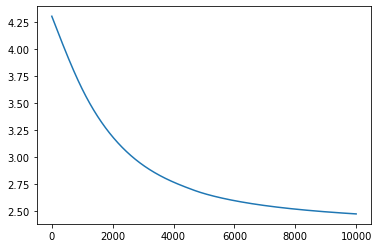

In [22]:
plt.plot(loss)